# Fine tuning and Contrastive Learning

In this draft, I want to show that learning using Contrastive Learning is better than learning without it.

[Contrastive learning in Pytorch, made simple](https://github.com/lucidrains/contrastive-learner)

[Contrastive Learning with SimCLR in PyTorch](https://www.geeksforgeeks.org/deep-learning/contrastive-learning-with-simclr-in-pytorch/)



In [ ]:
# Install libraries for contrastive learning method

# !pip install contrastive-learner
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.7 MB/s eta 0:00:00


## Get previously saved model file

In [ ]:
# Mount your Google Drive to this Colab
from google.colab import drive

gdrive = '/content/gdrive'
drive.mount(gdrive)

# Check connection
data_dir = f'{gdrive}/My Drive/Colab Notebooks/2025.07.25_execises/models'

# Show files in a data directory
!ls -hal "{data_dir}"

Mounted at /content/gdrive
total 2.0G
-rw------- 1 root root  16M Jul 28 11:26 3d_image_classification.keras
-rw------- 1 root root 249M Aug 12 12:49 brisc2025.zip
-rw------- 1 root root  32M Jul 30 16:32 dcgan_discriminator_celeb.pth.tar
-rw------- 1 root root  32M Jul 30 16:32 dcgan_discriminator_checkpoint.pth.tar
-rw------- 1 root root  41M Jul 30 16:32 dcgan_generator_celeb.pth.tar
-rw------- 1 root root 145M Jul 30 16:32 dcgan_generator_checkpoint.pth.tar
-rw------- 1 root root 239M Sep  2  2018 maps.tar.gz
-rw------- 1 root root  32M Aug  7 18:24 pix2pix_discriminator.pth.tar
-rw------- 1 root root 623M Aug  7 18:24 pix2pix_generator.pth.tar
-rw------- 1 root root 270M Aug 21 08:02 ResNet50_no_CL.pth.tar
-rw------- 1 root root 1.2M Jul 29 08:44 simple_gan_discriminator_checkpoint.pth.tar
-rw------- 1 root root 2.6M Jul 29 08:44 simple_gan_generator_checkpoint.pth.tar
-rw------- 1 root root 356M Aug 14 11:04 UNet_Brisc.pth.tar


In [ ]:
# Get previourly saved model

import os

MODEL_NAME = "ResNet50"
# MODEL_NAME = "ResNet18"

CHECKPOINT_FILE = f"{MODEL_NAME}_using_CL.pth.tar"  # name of pre-trained model checkpoint

# Copy files from Google Drive
if os.path.exists(f"{data_dir}/{CHECKPOINT_FILE}"):
    !cp -rf "{data_dir}/{CHECKPOINT_FILE}" "."
    !ls -hal "{CHECKPOINT_FILE}"

## Import libraries

In [ ]:
# import Python libraries
import os
import math
import random
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from tqdm import tqdm

# import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import models


def set_seed(seed: int = 42):
    """ Set random seed for reproducibility. """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = False
    cudnn.benchmark = True


set_seed()

## Set global variables

In [ ]:
# Set some global variables
NUM_WORKERS = multiprocessing.cpu_count()  # number of CPU kernels
print(f"Number of CPU kernels: {NUM_WORKERS}")

# Define the mean and std used for normalization (e.g., for CIFAR-10)
MEAN = torch.tensor([0.4914, 0.4822, 0.4465])  # mean value for CIFAR10 dataset
STD = torch.tensor([0.2023, 0.1994, 0.2010])  # standard deviation for CIFAR10

# Set device. Try to get GPU (`cuda`) device instead of CPU.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 1000  # Google Colab GPU RAM is 15 GB, system RAM is 12.7 GB
NUM_EPOCHS = 200  # 200, number of training epochs
PATIENCE = 12  # how long to wait after the last best improvement before stopping
LEARNING_RATE = 1e-4

CIFAR10_CLASSES = ("plane", "car", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck")

NUM_CLASSES = len(CIFAR10_CLASSES)  # number of classes in the dataset

Number of CPU kernels: 2


## Helper functions

[Get your monitor DPI here](https://www.infobyip.com/detectmonitordpi.php) for better images view.

In [ ]:
# MY_MONITOR_DPI = 120  # dots per inch (DPI)

# Checkpoints are snapshots of the model's state (weights, optimizer state, etc.)
#   and potentially the training progress (epoch number, patience counter,
#   best metric value, etc.) saved at various points during training.

LOAD_CHECKPOINT = True  # load pre-trained model from the file

TOTAL_EPOCHS = 0  # total number of train epochs
BEST_ACCURACY = 0  # best accuracy obtained
MINIMAL_LOSS = float("inf")  # minimal validation loss
TRAIN_HISTORY = {  # previous train history
    "train_accuracies": [],
    "train_losses": [],
    "test_accuracies": [],
    "test_losses": [],
}

CHECKPOINT = {  # set checkpoint dictionary
    "model_state_dict": None,  # model.state_dict() - weights and other information
    "optimizer_state_dict": None,  # optimizer.state_dict() - optimizer information
    "total_epochs": TOTAL_EPOCHS,  # current epoch number
    "best_accuracy": BEST_ACCURACY,  # current best accuracy
    "minimal_loss": MINIMAL_LOSS,  # current minimal loss
    "train_history": TRAIN_HISTORY,  # current train history
}


def save_checkpoint(checkpoint, checkpoint_file):
    torch.save(checkpoint, checkpoint_file)
    print(" => Save checkpoint")


def load_checkpoint(checkpoint_file, model, optimizer):
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    total_epochs = checkpoint["total_epochs"]
    best_accuracy = checkpoint["best_accuracy"]
    minimal_loss = checkpoint["minimal_loss"]
    train_history = checkpoint["train_history"]
    print(f" => Load checkpoint. Epochs: {total_epochs}. "
          f"Loss: {minimal_loss:.5f}. "
          f"Accuracy: {best_accuracy:.2f}%")
    return total_epochs, best_accuracy, minimal_loss, train_history


def show_image(fname, size=(10, 10), title=None):
    """ Show image in Jupyter Notebook. """
    # plt.rcParams['figure.dpi'] = MY_MONITOR_DPI  # set DPI
    plt.figure(figsize=size)  # set image size in inches
    image = plt.imread(fname)
    plt.title(title)
    plt.axis("off")  # turn off axis numbers
    plt.imshow(image)
    plt.axis("off")
    plt.show


def plot_accuracy(train_accuracies, test_accuracies):
    """ Plot accuracy curves. """
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy")
    plt.plot(range(len(test_accuracies)), test_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Model: {MODEL_NAME}. Accuracy: {BEST_ACCURACY:.2f}%. "
              f'Loss: {MINIMAL_LOSS:.5f}. Epochs: {TOTAL_EPOCHS}')
    plt.savefig(f"{MODEL_NAME}_accuracy_plot.png")
    plt.show()


def plot_loss(train_losses, test_losses):
    """ Plot loss curves. """
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
    plt.plot(range(len(test_losses)), test_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Minimal loss for {MODEL_NAME} is {MINIMAL_LOSS:.5f}")
    plt.savefig(f"{MODEL_NAME}_loss_plot.png")
    plt.show()

## Load and normalize CIFAR10 dataset

In [ ]:
# Set augmentations and transformations for train set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(MEAN, STD),  # normalize
])

# Get train set
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)

# Initialize train data set loader
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Set transformations for test set. Without augmentations.
transform_test = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(MEAN, STD),  # normalize
])

# Get test set
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)

# Initialize test data set loader
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

100%|██████████| 170M/170M [00:03<00:00, 46.3MB/s]


Show some of the training images.

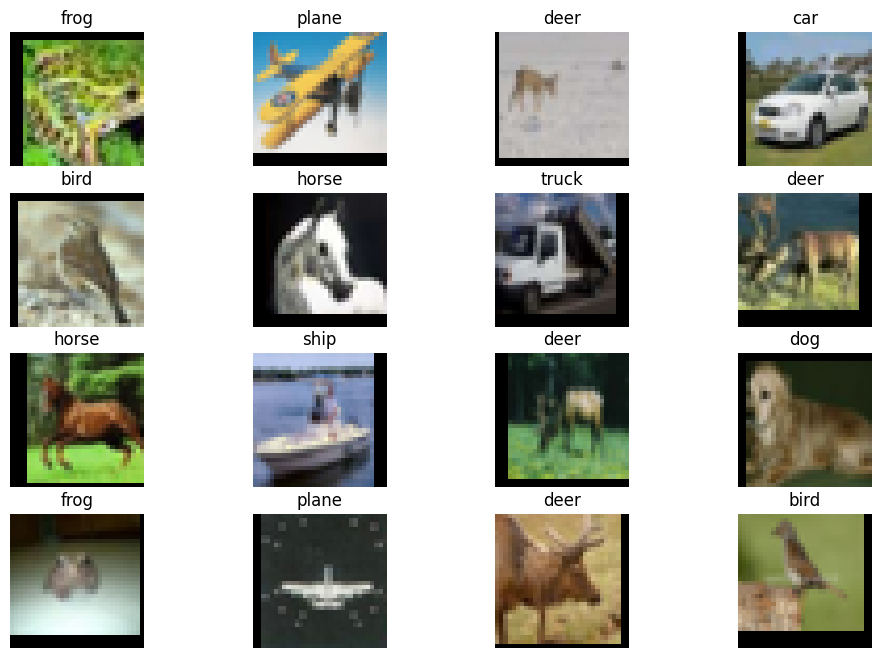

In [ ]:
def show(images_with_labels, cmap="viridis"):
    """ Show images in a grid with matplotlib.
        Default color map is "viridis". """
    fig = plt.figure(figsize=(12, 8))  # create figure with size 12×8 inches
    l = len(images_with_labels)  # get number of images to show
    rows = math.floor(math.sqrt(l))  # calculate number of rows in a grid
    cols = math.ceil(l / rows)  # calculate number of columns in a grid
    for i, (image, label) in enumerate(images_with_labels, 1):
        fig.add_subplot(rows, cols, i)  # add a new cell to the grid
        # prepare image for display
        image = image * STD.view(3, 1, 1) + MEAN.view(3, 1, 1)  # reverse the normalization
        image = torch.clamp(image, 0, 1)  # clamp values to the valid range [0, 1]
        image = image.numpy()  # convert from PyTorch to NumPy format
        # Transpose tensor channels from (channel, height, width) to (height, width, channel).
        # Thus, tensor shape (3, 32, 32) is transposed to (32, 32, 3).
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image, cmap=cmap)  # add image to grid
        plt.axis("off")  # turn off axis numbers
        plt.title(CIFAR10_CLASSES[label])  # show image title
    plt.show()  # show grid


# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
num = 16  # show 12 images
images_with_labels = list(zip(images[0:num], labels[0:num]))
show(images_with_labels)

## Load pre-trained ResNet50 neural network and fine-tune it for CIFAR10 dataset

The ResNet50 model pre-trained on ImageNet needs to be **fine-tuned** for the CIFAR10 dataset. That is, small changes need to be made to the architecture of the ResNet50 neural network so that the weights learned on the ImageNet dataset are applied to train the CIFAR10 dataset.

Original article about fine-tuning ResNet50 for CIFAR10 dataset: [Fine-Tuning ResNet50 pretrained on ImageNet for CIFAR-10](https://sidthoviti.com/fine-tuning-resnet50-pretrained-on-imagenet-for-cifar-10/)

In [ ]:
# Import ResNet50 model pretrained on ImageNet.
# Get the most up-to-date `weights` from ImageNet.
model = models.get_model(MODEL_NAME, weights=f"{MODEL_NAME}_Weights.DEFAULT")

print(f"{MODEL_NAME} before fine-tuning:\n")
print(model)  # print architecture as text

# Modify conv1 layer to suit CIFAR-10.
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected ("fc") layer according to the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)

print(f"\n\n------\n" f"{MODEL_NAME} after fine-tuning:\n")
print(model)  # print architecture as text

# Move the model to GPU if available
model = model.to(DEVICE)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Load previously saved model.
if LOAD_CHECKPOINT and os.path.exists(CHECKPOINT_FILE):
    print(f"\n\n------\n")
    TOTAL_EPOCHS, BEST_ACCURACY, TRAIN_HISTORY = load_checkpoint(
        CHECKPOINT_FILE, model, optimizer)
else:
    TOTAL_EPOCHS = 0
    BEST_ACCURACY = 0
    TRAIN_HISTORY = {
        "train_accuracies": [],
        "train_losses": [],
        "test_accuracies": [],
        "test_losses": [],
    }

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


ResNet50 before fine-tuning:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

## *(Optional)* Visualize a neural network

In [ ]:
%%script echo "Skip this cell."

# Creates a graph representation of the model's computation graph using Graphviz.
!pip install torchviz

from torchviz import make_dot


def show_model(model, batch, fname, size=(24, 36)):
    """ Show model using torchviz library. """
    batch = next(iter(train_loader))[0]  # get 1st image from batch of images
    output = model(batch)  # give dummy batch to forward().

    # Create a visualization of the computational graph
    dot = make_dot(output, params=dict(model.named_parameters()))

    # Save or display the generated graph
    name, extension = os.path.splitext(fname)
    dot.format = extension[1:]  # ".png" to "png"
    dot.render(os.path.basename(name))

    show_image(fname, size)  # show image in Colab
    # print(model)  # print architecture as text


batch = next(iter(train_loader))[0]  # dummy batch images

show_model(model, batch, f"{MODEL_NAME}_visualization1.png")
show_model(model, batch, f"{MODEL_NAME}_visualization2.png")

Skip this cell.


## Contrastive Learning Part of the Training

**Original source code**: [Contrastive learning in Pytorch, made simple](https://github.com/lucidrains/contrastive-learner) from the file [contrastive_learner.py](https://github.com/lucidrains/contrastive-learner/blob/master/contrastive_learner/contrastive_learner.py).

In [ ]:
import copy
import random
from functools import wraps

import torch
from torch import nn
import torch.nn.functional as F

from torchvision.models import resnet50
from kornia import augmentation as augs
from kornia import filters

# helper functions

def identity(x): return x

def default(val, def_val):
    return def_val if val is None else val

def flatten(t):
    return t.reshape(t.shape[0], -1)

def safe_concat(arr, el, dim=0):
    if arr is None:
        return el
    return torch.cat((arr, el), dim=dim)

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

# losses

def contrastive_loss(queries, keys, temperature = 0.1):
    b, device = queries.shape[0], queries.device
    logits = queries @ keys.t()
    logits = logits - logits.max(dim=-1, keepdim=True).values
    logits /= temperature
    return F.cross_entropy(logits, torch.arange(b, device=device))

def nt_xent_loss(queries, keys, temperature = 0.1):
    b, device = queries.shape[0], queries.device

    n = b * 2
    projs = torch.cat((queries, keys))
    logits = projs @ projs.t()

    mask = torch.eye(n, device=device).bool()
    logits = logits[~mask].reshape(n, n - 1)
    logits /= temperature

    labels = torch.cat(((torch.arange(b, device=device) + b - 1), torch.arange(b, device=device)), dim=0)
    loss = F.cross_entropy(logits, labels, reduction='sum')
    loss /= n
    return loss

# augmentation utils

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

# exponential moving average

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

# hidden layer extractor class

class OutputHiddenLayer(nn.Module):
    def __init__(self, net, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.hidden = None
        self._register_hook()

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _register_hook(self):
        def hook(_, __, output):
            self.hidden = output

        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(hook)

    def forward(self, x):
        if self.layer == -1:
            return self.net(x)

        _ = self.net(x)
        hidden = self.hidden
        self.hidden = None
        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

# main class

class ContrastiveLearner(nn.Module):
    def __init__(self, net, image_size, hidden_layer = -2, project_hidden = True, project_dim=128, augment_both=True, use_nt_xent_loss=False, augment_fn = None, use_bilinear = False, use_momentum = False, momentum_value = 0.999, key_encoder = None, temperature = 0.1):
        super().__init__()
        self.net = OutputHiddenLayer(net, layer=hidden_layer)

        DEFAULT_AUG = nn.Sequential(
            RandomApply(augs.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
            augs.RandomGrayscale(p=0.2),
            augs.RandomHorizontalFlip(),
            RandomApply(filters.GaussianBlur2d((3, 3), (1.5, 1.5)), p=0.1),
            augs.RandomResizedCrop((image_size, image_size))
        )

        self.augment = default(augment_fn, DEFAULT_AUG)

        self.augment_both = augment_both

        self.temperature = temperature
        self.use_nt_xent_loss = use_nt_xent_loss

        self.project_hidden = project_hidden
        self.projection = None
        self.project_dim = project_dim

        self.use_bilinear = use_bilinear
        self.bilinear_w = None

        self.use_momentum = use_momentum
        self.ema_updater = EMA(momentum_value)
        self.key_encoder = key_encoder

        # for accumulating queries and keys across calls
        self.queries = None
        self.keys = None

        # send a mock image tensor to instantiate parameters
        t = torch.randn(1, 3, image_size, image_size).to(device=DEVICE)
        self.forward(t)

    @singleton('key_encoder')
    def _get_key_encoder(self):
        key_encoder = copy.deepcopy(self.net)
        key_encoder._register_hook()
        return key_encoder

    @singleton('bilinear_w')
    def _get_bilinear(self, hidden):
        _, dim = hidden.shape
        return nn.Parameter(torch.eye(dim, device=device, dtype=dtype)).to(hidden)

    @singleton('projection')
    def _get_projection_fn(self, hidden):
        _, dim = hidden.shape

        return nn.Sequential(
            nn.Linear(dim, dim, bias = False),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim, self.project_dim, bias = False)
        ).to(hidden)

    def reset_moving_average(self):
        assert self.use_momentum, 'must be using momentum method for key encoder'
        del self.key_encoder
        self.key_encoder = None

    def update_moving_average(self):
        assert self.key_encoder is not None, 'key encoder has not been created yet'
        self.key_encoder = update_moving_average(self.ema_updater, self.key_encoder, self.net)

    def calculate_loss(self):
        assert self.queries is not None and self.keys is not None, 'no queries or keys accumulated'
        loss_fn = nt_xent_loss if self.use_nt_xent_loss else contrastive_loss
        loss = loss_fn(self.queries, self.keys, temperature = self.temperature)
        self.queries = self.keys = None
        return loss

    def forward(self, x, accumulate = False):
        b, c, h, w, device = *x.shape, x.device
        transform_fn = self.augment if self.augment_both else noop

        query_encoder = self.net
        queries = query_encoder(transform_fn(x))

        key_encoder = self.net if not self.use_momentum else self._get_key_encoder()
        keys = key_encoder(self.augment(x))

        if self.use_momentum:
            keys = keys.detach()

        queries, keys = map(flatten, (queries, keys))

        if self.use_bilinear:
            W = self._get_bilinear(keys)
            keys = (W @ keys.t()).t()

        project_fn = self._get_projection_fn(queries) if self.project_hidden else identity
        queries, keys = map(project_fn, (queries, keys))

        self.queries = safe_concat(self.queries, queries)
        self.keys = safe_concat(self.keys, keys)

        return self.calculate_loss() if not accumulate else None

In [ ]:
import torch
# from contrastive_learner import ContrastiveLearner


def train_contrastive_learning(model, loader, learner, opt, epochs):
    """ Train the `model` using Contrastive Learning method. """
    print(f'Run Contrastive Learning for {epochs} epochs')
    for e in range(1, epochs + 1):
        # Create progress bar
        loop = tqdm(enumerate(loader), total=len(loader), leave=False)
        loop.set_description(f'Contrastive Learning epoch [{e}/{epochs}]')

        for batch_idx, (images, labels) in loop:
            # Get data to CUDA (GPU) if possible
            images = images.to(device=DEVICE)
            # labels = labels.to(device=DEVICE)

            # train the model
            loss = learner(images)
            opt.zero_grad()
            loss.backward()
            opt.step()



model = model.to(DEVICE)
model.train()  # switch the model to train mode

learner = ContrastiveLearner(
    model,
    image_size = 32,
    hidden_layer = "avgpool",  # layer name where output is hidden dimension. this can also be an integer specifying the index of the child
    project_hidden = True,     # use projection head
    project_dim = 128,         # projection head dimensions, 128 from paper
    use_nt_xent_loss = True,   # the above mentioned loss, abbreviated
    temperature = 0.1,         # temperature
    augment_both = True        # augment both query and key
)

opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

# Run Contrastive Learning for 5 epochs before the main training.
train_contrastive_learning(model, train_loader, learner, opt, epochs=5)

Run Contrastive Learning for 5 epochs


## Train the network

**This is when things start to get interesting.**

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
def check_accuracy(loader, model, criterion, verbosity=False):
    """ Check accuracy on train or test dataset to see how good our model. """
    num_loss = 0.0
    num_correct = 0
    num_total = 0
    model.eval()  # switch the model to evaluation mode

    # Since there is no learning, we don't need to calculate gradients for outputs.
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=DEVICE)
            labels = labels.to(device=DEVICE)

            # Forward pass
            scores = model(images)
            loss = criterion(scores, labels)

            # data for training history
            num_loss += loss.item() * images.size(0)  # update mean loss
            _, predicted = torch.max(scores, 1)  # get index of max value
            num_correct += (predicted == labels).sum().item()
            num_total += labels.size(0)

    # Get accuracy and mean_loss
    mean_loss = num_loss / len(loader.dataset)
    accuracy = float(num_correct) / float(num_total) * 100

    if verbosity:  # get more output information
        data = "train" if loader.dataset.train else "test"
        print(f"Accuracy for {data} set: {accuracy:.2f}%. "
              f"Correct {num_correct} from {num_total} samples.")

    model.train()  # switch the model to train mode
    return accuracy, mean_loss




model.train()  # switch the model to train mode
no_improvement_count = 0  # number of epochs with no improvement

# Initialize train and test accuracies and loses for prots.
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

# Train the network
e = TOTAL_EPOCHS + NUM_EPOCHS
for epoch in range(TOTAL_EPOCHS + 1, e + 1):
    num_loss = 0.0  # train loss
    train_total = 0  # total number of images
    train_correct = 0  # number of correctly predicted images

    # Apply Contrastive Learning method every 3 epochs in the main loop.
    if epoch % 7 == 0:
        # Run Contrastive Learning for 3 epochs
        train_contrastive_learning(model, train_loader, learner, opt, epochs=3)

    # Create progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    loop.set_description(f'Epoch [{epoch}/{e}]')

    for batch_idx, (images, labels) in loop:
        # Get data to CUDA (GPU) if possible
        images = images.to(device=DEVICE)
        labels = labels.to(device=DEVICE)

        # Forward pass
        scores = model(images)  # pass images through a neural network
        loss = criterion(scores, labels)

        # Backward pass
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # apply the backpropagation method

        # Change model weights. Gradient descent or Adam step
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        # data for training history
        num_loss += loss.item() * images.size(0)  # update train loss
        _, predicted = torch.max(scores, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Check accuracy and save a checkpoint at the end of each epoch.
    test_accuracy, test_loss = check_accuracy(test_loader, model, criterion)

    # Compute training history
    train_accuracy = 100.0 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_loss = num_loss / len(train_loader.dataset)  # mean train loss
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Show current information
    message = (f'Epoch: {epoch} from {e}. '
               f'Loss: {test_loss:.5f}. '
               f'Accuracy: {test_accuracy:.2f}%')

    # model improved
    if MINIMAL_LOSS > test_loss:
        print(message, end="")
        no_improvement_count = 0
        TOTAL_EPOCHS = epoch
        BEST_ACCURACY = test_accuracy
        MINIMAL_LOSS = test_loss
        TRAIN_HISTORY["train_accuracies"] += train_accuracies
        TRAIN_HISTORY["train_losses"] += train_losses
        TRAIN_HISTORY["test_accuracies"] += test_accuracies
        TRAIN_HISTORY["test_losses"] += test_losses
        CHECKPOINT = {
            "model_state_dict": model.state_dict(),  # weights and other information
            "optimizer_state_dict": optimizer.state_dict(),  # optimizer information
            "total_epochs": TOTAL_EPOCHS,  # current epoch number
            "best_accuracy": BEST_ACCURACY,  # current best accuracy
            "minimal_loss": MINIMAL_LOSS,  # current minimal loss
            "train_history": TRAIN_HISTORY,  # current train history
        }
        save_checkpoint(CHECKPOINT, CHECKPOINT_FILE)
        # Re-initialize train and test accuracies and loses
        train_accuracies = []
        train_losses = []
        test_accuracies = []
        test_losses = []

    else:  # no improvement
        print(message)
        no_improvement_count += 1
        # Exit from training if no improvement for "patience" epoch.
        if no_improvement_count >= PATIENCE:
            print(f"Stopping early as no improvement has been observed"
                  f"in {PATIENCE} epochs.")
            break  # exit from the training cycle

Epoch: 1 from 200. Loss: 1.00834. Accuracy: 64.16% => Save checkpoint


Epoch: 2 from 200. Loss: 0.72211. Accuracy: 74.67% => Save checkpoint


Epoch: 3 from 200. Loss: 0.59939. Accuracy: 79.43% => Save checkpoint


Epoch: 4 from 200. Loss: 0.53578. Accuracy: 81.45% => Save checkpoint


Epoch: 5 from 200. Loss: 0.47771. Accuracy: 83.57% => Save checkpoint


Epoch: 6 from 200. Loss: 0.45160. Accuracy: 84.44% => Save checkpoint
Run Contrastive Learning for 3 epochs


Epoch: 7 from 200. Loss: 0.47119. Accuracy: 83.93%


Epoch: 8 from 200. Loss: 0.40768. Accuracy: 85.98% => Save checkpoint


Epoch: 9 from 200. Loss: 0.39328. Accuracy: 86.67% => Save checkpoint


Epoch: 10 from 200. Loss: 0.37380. Accuracy: 87.56% => Save checkpoint


Epoch: 11 from 200. Loss: 0.36046. Accuracy: 88.01% => Save checkpoint


Epoch: 12 from 200. Loss: 0.35226. Accuracy: 88.47% => Save checkpoint


Epoch: 13 from 200. Loss: 0.34982. Accuracy: 88.75% => Save checkpoint
Run Contrastive Learning for 3 epochs


Epoch: 14 from 200. Loss: 0.35411. Accuracy: 88.13%


Epoch: 15 from 200. Loss: 0.33871. Accuracy: 88.92% => Save checkpoint


Epoch: 16 from 200. Loss: 0.33629. Accuracy: 89.06% => Save checkpoint


Epoch: 17 from 200. Loss: 0.33851. Accuracy: 89.60%


Epoch: 18 from 200. Loss: 0.34838. Accuracy: 89.54%


Epoch: 19 from 200. Loss: 0.35325. Accuracy: 89.88%


Epoch: 20 from 200. Loss: 0.36486. Accuracy: 89.66%
Run Contrastive Learning for 3 epochs


Epoch: 21 from 200. Loss: 0.33551. Accuracy: 89.43% => Save checkpoint


Epoch: 22 from 200. Loss: 0.35367. Accuracy: 89.89%


Epoch: 23 from 200. Loss: 0.36569. Accuracy: 90.19%


Epoch: 24 from 200. Loss: 0.37104. Accuracy: 90.12%


Epoch: 25 from 200. Loss: 0.37823. Accuracy: 90.29%


Epoch: 26 from 200. Loss: 0.38477. Accuracy: 90.55%


Epoch: 27 from 200. Loss: 0.39454. Accuracy: 90.13%
Run Contrastive Learning for 3 epochs


Epoch: 28 from 200. Loss: 0.35196. Accuracy: 90.21%


Epoch: 29 from 200. Loss: 0.38664. Accuracy: 90.20%


Epoch: 30 from 200. Loss: 0.39492. Accuracy: 90.22%


Epoch: 31 from 200. Loss: 0.39691. Accuracy: 90.50%


Epoch: 32 from 200. Loss: 0.39966. Accuracy: 90.65%


Epoch: 33 from 200. Loss: 0.42194. Accuracy: 90.39%
Stopping early as no improvement has been observedin 12 epochs.


## Check neural network accuracy for CIFAR10 dataset

 => Load checkpoint. Epochs: 21. Loss: 0.33551. Accuracy: 89.43%


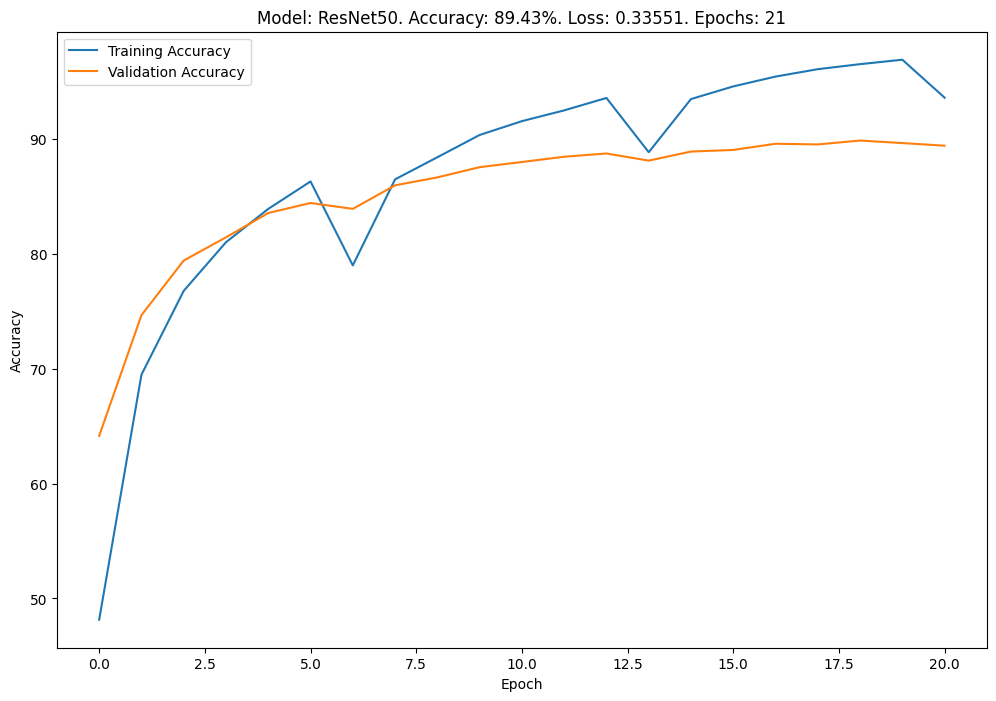

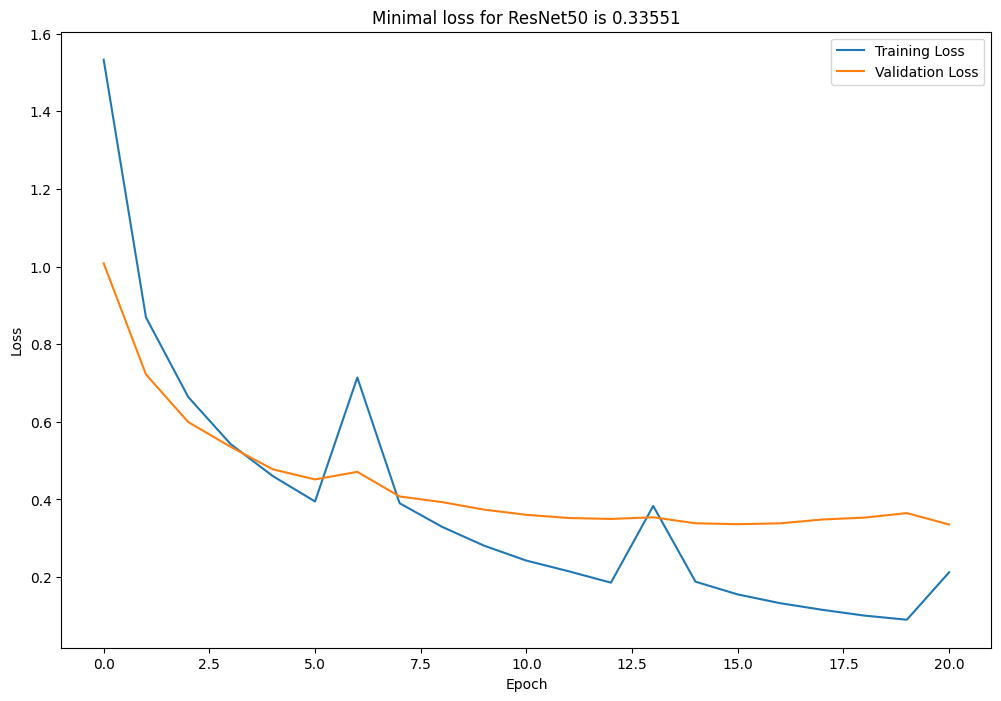

In [ ]:
# # The "_" sign means that the function output is not used here.
# # Therefore, the "_" sign is a stub.
# _ = check_accuracy(train_loader, model, criterion, verbosity=True)
# _ = check_accuracy(test_loader, model, criterion, verbosity=True)

# Load checkpoint
TOTAL_EPOCHS, BEST_ACCURACY, MINIMAL_LOSS, TRAIN_HISTORY = load_checkpoint(
        CHECKPOINT_FILE, model, optimizer)

# Get training history from the checkpoint
train_accuracies = TRAIN_HISTORY["train_accuracies"]
train_losses = TRAIN_HISTORY["train_losses"]
test_accuracies = TRAIN_HISTORY["test_accuracies"]
test_losses = TRAIN_HISTORY["test_losses"]

# Show training history
plot_accuracy(train_accuracies, test_accuracies)
plot_loss(train_losses, test_losses)

## Save results to Google Drive

In [ ]:
pictures_dir = os.path.dirname(data_dir) + '/pictures'
print(pictures_dir)

!cp -rf "{CHECKPOINT_FILE}"               "{data_dir}"
!cp -rf "{MODEL_NAME}_accuracy_plot.png"  "{pictures_dir}"
!cp -rf "{MODEL_NAME}_loss_plot.png"      "{pictures_dir}"

/content/gdrive/My Drive/Colab Notebooks/2025.07.25_execises/pictures


Learning curves using the contrastive learning method.

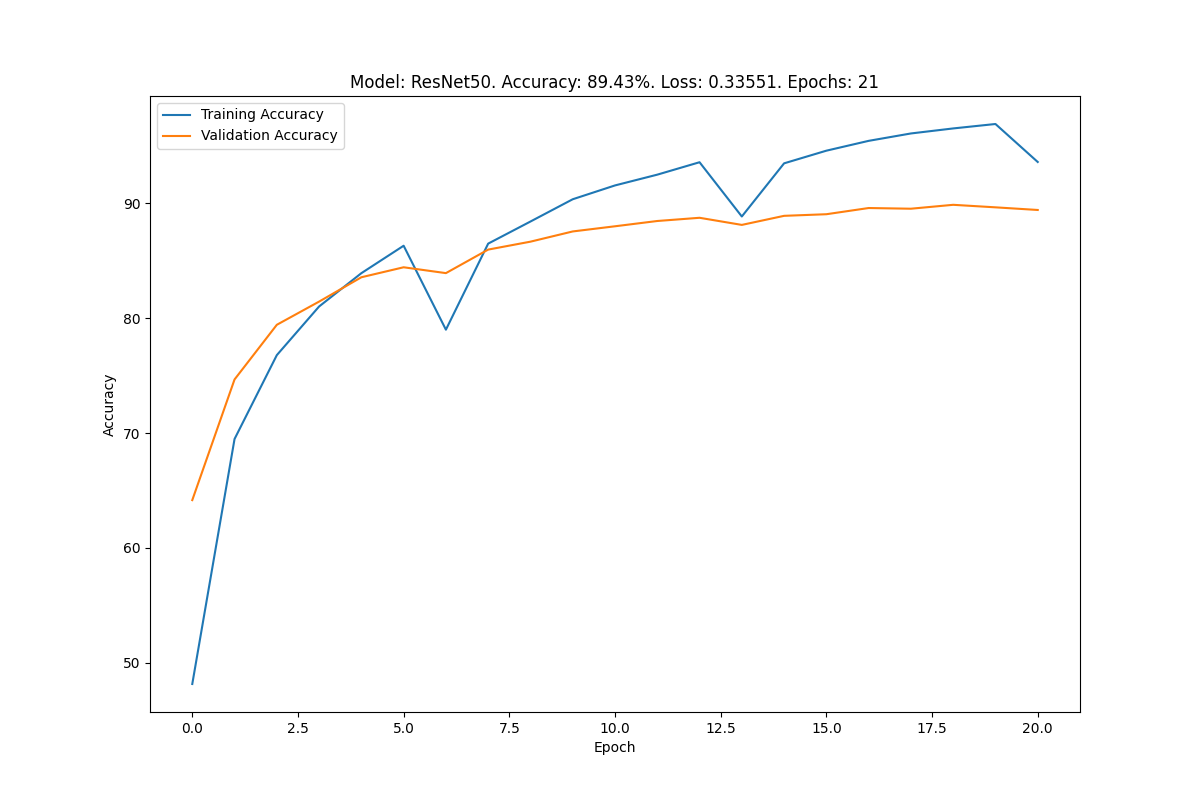

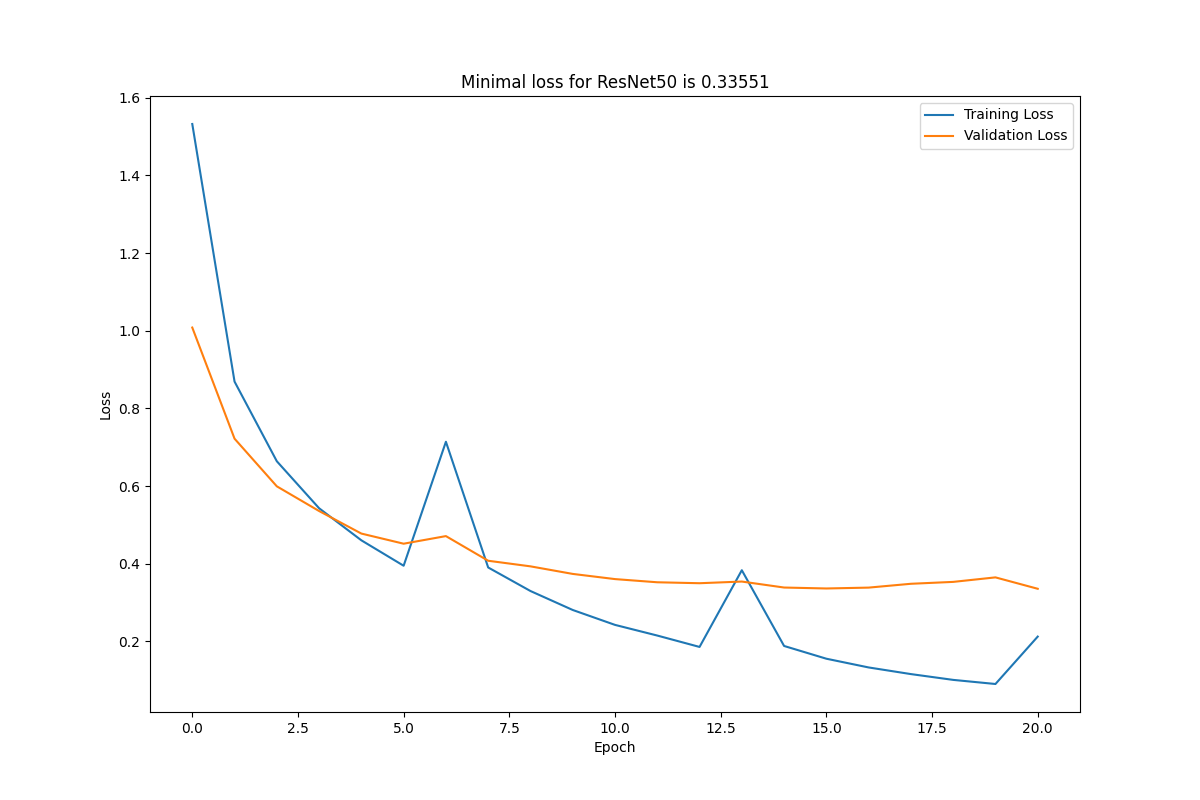


## Log with Results

[CIFAR-10 - Object Recognition in Images Leaderboard](https://www.kaggle.com/c/cifar-10/leaderboard)

**Best** Kabble result from the Leaderboard: **95.53%**.

### Date 18.08.2025

#### **Training without Contrastive Learning**

Run-1:

    Epoch: 52. Loss: 0.51133. Accuracy: 89.82%

#### **Training using Contrastive Learning**

Run-1.  Ten (10) CL epochs **only** at the beginning:

    Epoch: 16. Loss: 0.37645. Accuracy: 89.54%

Run-2. Every 3rd epoch. Continue previous Run-1:

    Epoch: 23. Loss: 0.37800. Accuracy: 90.27%

Run-3. Train Contrastive Learning for 5 epochs at the beginning. Then train Contrastive Learning for 3 epochs every 3rd epoch:

    Epoch: 17. Loss: 0.32958. Accuracy: 90.35%

Run-4. Continue previous Run-3, but use Contrastive Learning method every 5th epoch.

**Note:** the loss start to increase after epoch 22. This is a slight overfitting:

    Epoch: 22. Loss: 0.31387. Accuracy: 90.67%
    Epoch: 29. Loss: 0.34811. Accuracy: 91.08%

### Date 21.08.2025

#### Run 1
Training without Contrastive Learning. Search for the **minimal loss**, but not the maximal accuracy.

    Epoch: 12 from 200. Loss: 0.37599. Accuracy: 88.03%

#### Run 2
Training **using** Contrastive Learning. Search for the **minimal loss**.

Note 1: CL uses more memory than supervised learning. About 2x more GPU RAM.

Note 2: Also, more time for training is needed. About 2x more time.

    Epoch: 21 from 200. Loss: 0.33551. Accuracy: 89.43%

## Conclusions

Using unsupervised machine learning methods like Comparative Learning method allows us to reduce the loss and achieve higher accuracy. However, training with Contrastive Learning uses about 2x more GPU RAM and about 2x more time.

For example, to train ResNet50 on CIFAR10 dataset with and without Contrastive Learning (CL) method:

| Method | Epochs | Test Loss | Test Accuracy, % |
|---|---|---|---|
| Without CL | 12 | ≈ 0.376 | 88.03 |
| Using CL   | 21 | ≈ 0.336 | 89.43 |

In general, using unsupervised learning methods in the main training loop results in more stable model convergence.